# Capstone Project - The Battle of Neighborhoods (Week 2), Coursera Applied Data Science Capstone

# Introduction/Business Problem

The purpose of this project is to determine the similarity between various multicultural cities. This could have a casual purpose, if someone would like move to a different multicultural city, and would like to know how similar it is to determine whether they would be able to adapt to that location. However, it could serve a more professional purpose, if a contractor wanted to start a new business, and has or knows of a successful business in a multicultural city, then he or she could choose a new location that is similar to the old multicultural city.

# Data/Methodology

Data
According to https://www.orientrailjourneys.com/blog/10-multicultural-cities-in-the-world/: Toronto, Canada, Los Angeles, USA, and Sydney, Australia are the top three most multicultural cities in the world, and will thus be used for this project. I will use Wikipedia pages to get a list of neighborhoods in these three cities. The links are below:

Toronto: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

Los Angeles: https://en.wikipedia.org/wiki/List_of_districts_and_neighborhoods_of_Los_Angeles

Sydney: https://en.wikipedia.org/wiki/List_of_Sydney_suburbs

From these neighborhoods, I will utilize the Foursquare API to find the top 10 most common venues that are within a 500 meter radius of the neighborhood. Then, I will run k-means of all neighborhoods to cluster them into five clusters based on the top 10 most common venues. Lastly, I will compare each city's individual distributions of these five clusters to compare their similarity. Similar cities would have similar distributions of clusters.

This section contains code for data cleaning.

In [198]:
import pandas as pd
import numpy as np
import os

!conda install -c anaconda beautifulsoup4 --yes
from bs4 import BeautifulSoup
import requests

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium

print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.11

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - beautifulsoup4


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.6.16          |           py36_1         156 KB  anaconda

The following packages will be UPDATED:

    certifi: 2019.6.16-py36_1  conda-forge --> 2019.6.16-py36_1  anaconda
    openssl: 1.0.2r-h14c3975_0 conda-forge --> 1.0.2s-h7b6447c_0 anaconda


certifi-2019.6.16    | 156 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  curre

## Toronto, Canada Data

In [5]:
website_url = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M").text

toronto_soup = BeautifulSoup(website_url, "html")
print(toronto_soup.prettify())

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   List of postal codes of Canada: M - Wikipedia
  </title>
  <script>
   document.documentElement.className=document.documentElement.className.replace(/(^|\s)client-nojs(\s|$)/,"$1client-js$2");RLCONF={"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_postal_codes_of_Canada:_M","wgTitle":"List of postal codes of Canada: M","wgCurRevisionId":906439794,"wgRevisionId":906439794,"wgArticleId":539066,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Communications in Ontario","Postal codes in Canada","Toronto","Ontario-related lists"],"wgBreakFrames":!1,"wgPageContentLanguage":"en","wgPageContentModel":"wikitext","wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June",

In [36]:
cells = toronto_soup.find("table", {"class" : "wikitable sortable"})

toronto_table = []
for cell in cells:
    for thing in cells.find_all("td"):
        text = thing.text.strip()
        toronto_table.append(text)

toronto_df1 = pd.DataFrame()
toronto_postcodes = []
toronto_boroughs = []
toronto_neighborhoods = []

for index in range(0, len(toronto_table)):
    if index % 3 == 0:
        toronto_postcodes.append(toronto_table[index])
    if index % 3 == 1:
        toronto_boroughs.append(toronto_table[index])
    if index % 3 == 2:
        toronto_neighborhoods.append(toronto_table[index])

toronto_df1["Postcode"] = toronto_postcodes
toronto_df1["Borough"] = toronto_boroughs
toronto_df1["Neighborhood"] = toronto_neighborhoods

for index in range(len(toronto_df1["Borough"])):
    if toronto_df1["Borough"][index] == "Not assigned":
        toronto_df1.drop([index], axis = 0, inplace = True)
toronto_df1.reset_index(drop = True, inplace = True)

for index in range(len(toronto_df1["Neighborhood"])):
    if toronto_df1["Neighborhood"][index] == "Not assigned":
        toronto_df1["Neighborhood"][index] = toronto_df1["Borough"][index]
        
toronto_postcodes2 = [] 
for postcode in toronto_df1["Postcode"]:
    if postcode not in toronto_postcodes2:
        toronto_postcodes2.append(postcode)

toronto_neighborhoods2 = [[] for index in range(len(toronto_postcodes2))]
for thing in toronto_postcodes2:
    for index in range(len(toronto_df1["Postcode"])):
        if toronto_df1["Postcode"][index] == thing:
            if toronto_df1["Neighborhood"][index] not in toronto_neighborhoods2[(toronto_postcodes2.index(thing))]:
                toronto_neighborhoods2[(toronto_postcodes2.index(thing))].append(toronto_df1["Neighborhood"][index])

toronto_list1 = []
for thing in toronto_postcodes2:
    toronto_list1.append(list(toronto_df1["Postcode"]).index(thing))

toronto_boroughs2 = []
for index in toronto_list1:
    toronto_boroughs2.append(toronto_df1["Borough"][index])

toronto_df2 = pd.DataFrame()
toronto_df2["Postcode"] = toronto_postcodes2
toronto_df2["Borough"] = toronto_boroughs2
toronto_df2["Neighborhood"] = toronto_neighborhoods2

def listToString(list):  
    string = ""
    
    for element in list:
        if list.index(element) + 1 == len(list):
            string = string + element
        else:
            string = string + element + ", "   
  
    return string

for index in range(len(toronto_df2["Neighborhood"])):
    toronto_df2["Neighborhood"][index] = listToString(toronto_df2["Neighborhood"][index])

In [37]:
toronto_df3 = pd.read_csv("http://cocl.us/Geospatial_data")

toronto_latitude = []
for thing in list(toronto_df2["Postcode"]):
    for index in range(len(toronto_df2["Postcode"])):
        if toronto_df3["Postal Code"][index] == thing:
            toronto_latitude.append(toronto_df3["Latitude"][index])

toronto_longitude = []
for thing in list(toronto_df2["Postcode"]):
    for index in range(len(toronto_df2["Postcode"])):
        if toronto_df3["Postal Code"][index] == thing:
            toronto_longitude.append(toronto_df3["Longitude"][index])
            
toronto_df2["Latitude"] = toronto_latitude
toronto_df2["Longitude"] = toronto_longitude
toronto_df3 = toronto_df2[toronto_df2["Borough"].str.contains("Toronto")].reset_index(drop = True)

toronto_data = toronto_df3.drop(columns = ["Postcode", "Borough"])

In [25]:
toronto_outname = "toronto_data_export.csv"
toronto_outdir = "./"
if not os.path.exists(toronto_outdir):
    os.mkdir(toronto_outdir)

toronto_data_export = os.path.join(toronto_outdir, toronto_outname)    

toronto_data.to_csv(toronto_data_export)

In [2]:
toronto_data_no = pd.read_csv("toronto_data_export.csv")
toronto_data_USE = toronto_data_no.drop(columns = ["Unnamed: 0"])
print(toronto_data_USE)

                                         Neighborhood   Latitude  Longitude
0                           Harbourfront, Regent Park  43.654260 -79.360636
1                            Ryerson, Garden District  43.657162 -79.378937
2                                      St. James Town  43.651494 -79.375418
3                                         The Beaches  43.676357 -79.293031
4                                         Berczy Park  43.644771 -79.373306
5                                  Central Bay Street  43.657952 -79.387383
6                                            Christie  43.669542 -79.422564
7                            Adelaide, King, Richmond  43.650571 -79.384568
8                        Dovercourt Village, Dufferin  43.669005 -79.442259
9   Harbourfront East, Toronto Islands, Union Station  43.640816 -79.381752
10                           Little Portugal, Trinity  43.647927 -79.419750
11                       The Danforth West, Riverdale  43.679557 -79.352188
12          

## Los Angeles, USA Data

In [22]:
los_angeles_url = requests.get("https://en.wikipedia.org/wiki/List_of_districts_and_neighborhoods_of_Los_Angeles").text

los_angeles_soup = BeautifulSoup(los_angeles_url, "html")
print(los_angeles_soup.prettify())

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   List of districts and neighborhoods of Los Angeles - Wikipedia
  </title>
  <script>
   document.documentElement.className=document.documentElement.className.replace(/(^|\s)client-nojs(\s|$)/,"$1client-js$2");RLCONF={"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_districts_and_neighborhoods_of_Los_Angeles","wgTitle":"List of districts and neighborhoods of Los Angeles","wgCurRevisionId":901772896,"wgRevisionId":901772896,"wgArticleId":1647580,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["All articles with unsourced statements","Articles with unsourced statements from July 2013","Articles with unsourced statements from January 2016","Neighborhoods in Los Angeles","Geography of Los Angeles","Lists of neighborhoods in U.S. cities","Lists of populated places in Calif

In [23]:
list1 = []

for thing in los_angeles_soup.find_all("a"):
    list1.append(thing.get("title"))
        
list2 = [] 
for thing in list1: 
    if thing != None : 
        list2.append(thing) 
        
list3 = []
for thing in list2:
    if thing.endswith("Los Angeles") and "," in thing:
        list3.append(thing)

list_4 = list3[:-2]

los_angeles_neighborhoods = []
for thing in list_4:
    los_angeles_neighborhoods.append(thing.replace(", Los Angeles", ""))

print(los_angeles_neighborhoods)

['Angelino Heights', 'Arleta', 'Arlington Heights', 'Arts District', 'Atwater Village', 'Baldwin Hills', 'Baldwin Hills/Crenshaw', 'Baldwin Village', 'Baldwin Vista', 'Beachwood Canyon', 'Bel Air', 'Benedict Canyon', 'Beverly Crest', 'Beverly Glen', 'Beverly Grove', 'Beverly Park', 'Beverlywood', 'Boyle Heights', 'Brentwood', 'Brentwood Circle', 'Brentwood Glen', 'Broadway-Manchester', 'Brookside', 'Bunker Hill', 'Canoga Park', 'Harvard Park', 'Carthay', 'Castle Heights', 'Central-Alameda', 'Century City', 'Chatsworth', 'Chesterfield Square', 'Cheviot Hills', 'Chinatown', 'Civic Center', 'Crenshaw', 'Crestwood Hills', 'Cypress Park', 'Del Rey', 'Eagle Rock', 'East Gate Bel Air', 'East Hollywood', 'Echo Park', 'Edendale', 'El Sereno', 'Elysian Heights', 'Elysian Park', 'Elysian Valley', 'Encino', 'Exposition Park', 'Faircrest Heights', 'Fairfax District', 'Fashion District', 'Historic Filipinotown', 'Financial District', 'Florence', 'Franklin Hills', 'Gallery Row', 'Garvanza', 'Glassell

In [24]:
los_angeles_df1 = pd.DataFrame()
los_angeles_df1["Neighborhood"] = los_angeles_neighborhoods

los_angeles_latitude = []
los_angeles_error = []
for index in range(len(los_angeles_neighborhoods)):
    geolocator = Nominatim(user_agent = "frederick")
    location = geolocator.geocode(los_angeles_neighborhoods[index])
    
    if location == None:
        los_angeles_error.append(los_angeles_neighborhoods[index])
    else:
        los_angeles_latitude.append(location.latitude)

In [27]:
for thing in los_angeles_error:
    index = los_angeles_df1[los_angeles_df1["Neighborhood"] == thing].index
    los_angeles_df1.drop(index, inplace = True)

los_angeles_df1.reset_index(drop = True, inplace = True)

In [28]:
los_angeles_longitude = []

for index in range(len(los_angeles_df1["Neighborhood"])):
    geolocator = Nominatim(user_agent = "frederick")
    location = geolocator.geocode(los_angeles_df1["Neighborhood"][index])
    
    if location == None:
        los_angeles_error.append(los_angeles_df1["Neighborhood"][index])
    else:
        los_angeles_longitude.append(location.longitude)

In [30]:
los_angeles_df1["Latitude"] = los_angeles_latitude
los_angeles_df1["Longitude"] = los_angeles_longitude

los_angeles_data = los_angeles_df1

In [32]:
los_angeles_outname = "los_angeles_data_export.csv"
los_angeles_outdir = "./"
if not os.path.exists(los_angeles_outdir):
    os.mkdir(los_angeles_outdir)

los_angeles_data_export = os.path.join(los_angeles_outdir, los_angeles_outname)    

los_angeles_data.to_csv(los_angeles_data_export)

In [3]:
los_angeles_data_no = pd.read_csv("los_angeles_data_export.csv")
los_angeles_data_USE = los_angeles_data_no.drop(columns = ["Unnamed: 0"])
print(los_angeles_data_USE)

          Neighborhood   Latitude   Longitude
0     Angelino Heights  34.070289 -118.254797
1               Arleta  34.241327 -118.432205
2    Arlington Heights  42.081156  -87.980216
3        Arts District  32.788325  -96.799347
4      Atwater Village  34.116398 -118.256464
..                 ...        ...         ...
172      Wilshire Park  35.584277  -82.611794
173     Windsor Square  34.072593 -118.320810
174           Winnetka  42.108070  -87.736529
175     Woodland Hills  34.168436 -118.605838
176     Yucca Corridor  36.176332 -115.135430

[177 rows x 3 columns]


## Sydney, Australia Data

The following code was ran in a separate Jupyter notebook and imported here.

In [ ]:
sydney_url = requests.get("https://en.wikipedia.org/wiki/List_of_Sydney_suburbs").text

sydney_soup = BeautifulSoup(sydney_url, "html")
print(sydney_soup.prettify())

In [ ]:
list1 = []

for thing in sydney_soup.find_all("a"):
    list1.append(thing.get("title"))
        
list2 = [] 
for thing in list1: 
    if thing != None : 
        list2.append(thing) 
        
list3 = []
for thing in list2:
    if thing.endswith("New South Wales") and "," in thing:
        list3.append(thing)

list_4 = list3[11:686]

sydney_neighborhoods = []
for thing in list_4:
    sydney_neighborhoods.append(thing.replace(", New South Wales", ""))

print(sydney_neighborhoods)

In [ ]:
sydney_df1 = pd.DataFrame()
sydney_df1["Neighborhood"] = sydney_neighborhoods

sydney_latitude = []
sydney_longitude = []
sydney_error = []
for index in range(len(sydney_neighborhoods)):
    geolocator = Nominatim(user_agent = "frederick", timeout = 3)
    location = geolocator.geocode(sydney_neighborhoods[index])
    
    if location == None:
        sydney_error.append(sydney_neighborhoods[index])
    else:
        sydney_latitude.append(location.latitude)
        sydney_longitude.append(location.longitude)

In [ ]:
for thing in sydney_error:
    index = sydney_df1[sydney_df1["Neighborhood"] == thing].index
    sydney_df1.drop(index, inplace = True)

sydney_df1.reset_index(drop = True, inplace = True)

In [ ]:
sydney_df1["Latitude"] = sydney_latitude
sydney_df1["Longitude"] = sydney_longitude

sydney_data = sydney_df1

In [4]:
sydney_data_no = pd.read_csv("sydney_data_export.csv")
sydney_data_USE = sydney_data_no.drop(columns = ["Unnamed: 0"])
print(sydney_data_USE)

       Neighborhood   Latitude   Longitude
0        Abbotsbury  50.666320   -2.598968
1        Abbotsford  49.052116 -122.329479
2    Acacia Gardens -33.732459  150.912532
3       Agnes Banks -33.614508  150.711448
4             Airds -34.090000  150.826111
..              ...        ...         ...
669      Yarramundi -31.234753  148.467871
670     Yarrawarrah -34.056681  151.030888
671         Yennora -33.862008  150.968610
672       Yowie Bay -34.050278  151.103333
673         Zetland -33.907662  151.208218

[674 rows x 3 columns]


## Find the Top 10 Most Common Venues

In [33]:
CLIENT_ID = "N0WE1LGQ5UY1GZVVG3VUVA2SCTJ5HX3BAV4ATUAHLOV4N5E5"
CLIENT_SECRET = "CJQWTNKFXCDISJWRDRWHSAWKTTC2TVUDENWGTBS1R5EI30QG"
VERSION = "20190808"

In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            100, # radius = 100
            500) # LIMIT = 500
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [7]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[2:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [54]:
toronto_venues = getNearbyVenues(names = toronto_data_USE['Neighborhood'],
                                   latitudes = toronto_data_USE['Latitude'],
                                   longitudes = toronto_data_USE['Longitude']
                                  )

Harbourfront, Regent Park
Ryerson, Garden District
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Adelaide, King, Richmond
Dovercourt Village, Dufferin
Harbourfront East, Toronto Islands, Union Station
Little Portugal, Trinity
The Danforth West, Riverdale
Design Exchange, Toronto Dominion Centre
Brockton, Exhibition Place, Parkdale Village
The Beaches West, India Bazaar
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North, Forest Hill West
High Park, The Junction South
North Toronto West
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
Harbord, University of Toronto
Runnymede, Swansea
Moore Park, Summerhill East
Chinatown, Grange Park, Kensington Market
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Rosedale
Stn A PO Boxes 25 The Esplanade
Cabbagetown, St. James Town
Fir

In [55]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix = "", prefix_sep = "")
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()

In [57]:
toronto_grouped_outname = "toronto_grouped_export.csv"
toronto_grouped_outdir = "./"
if not os.path.exists(toronto_grouped_outdir):
    os.mkdir(toronto_grouped_outdir)

toronto_grouped_export = os.path.join(toronto_grouped_outdir, toronto_grouped_outname)    
toronto_grouped.to_csv(toronto_grouped_export)

,Neighborhood,American Restaurant,Art Gallery,Asian Restaurant,Bakery,Bank,Bar,Bookstore,Boutique,Breakfast Spot,...,Steakhouse,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Yoga Studio
0,"Adelaide, King, Richmond",0.0,0.0,0.0,0.0,0.0,0.083333,0.0,0.0,0.0,...,0.083333,0.0,0.083333,0.083333,0.0,0.0,0.0,0.0,0.083333,0.0
1,"CN Tower, Bathurst Quay, Island airport, Harbo...",0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
2,"Cabbagetown, St. James Town",0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
3,Central Bay Street,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
4,"Chinatown, Grange Park, Kensington Market",0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.2,0.0,0.0,0.000000,0.0


In [5]:
toronto_grouped_no = pd.read_csv("toronto_grouped_export.csv")
toronto_grouped_USE = toronto_grouped_no.drop(columns = ["Unnamed: 0"])
toronto_grouped_USE.head()

,Neighborhood,American Restaurant,Art Gallery,Asian Restaurant,Bakery,Bank,Bar,Bookstore,Boutique,Breakfast Spot,...,Steakhouse,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Yoga Studio
0,"Adelaide, King, Richmond",0.0,0.0,0.0,0.0,0.0,0.083333,0.0,0.0,0.0,...,0.083333,0.0,0.083333,0.083333,0.0,0.0,0.0,0.0,0.083333,0.0
1,"CN Tower, Bathurst Quay, Island airport, Harbo...",0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
2,"Cabbagetown, St. James Town",0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
3,Central Bay Street,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
4,"Chinatown, Grange Park, Kensington Market",0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.2,0.0,0.0,0.000000,0.0


In [8]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

toronto_columns = ["City", "Neighborhood"]
for ind in np.arange(num_top_venues):
    try:
        toronto_columns.append('{}{} Most Common Venue'.format(ind + 1, indicators[ind]))
    except:
        toronto_columns.append('{}th Most Common Venue'.format(ind + 1))

toronto_neighborhoods_venues_sorted = pd.DataFrame(columns=toronto_columns)
toronto_neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped_USE['Neighborhood']

for ind in np.arange(toronto_grouped_USE.shape[0]):
    toronto_neighborhoods_venues_sorted.iloc[ind, 2:] = return_most_common_venues(toronto_grouped_USE.iloc[ind, :], num_top_venues)

toronto_neighborhoods_venues_sorted["City"] = ["Toronto"] * (len(toronto_neighborhoods_venues_sorted["Neighborhood"]))   

toronto_neighborhoods_venues_sorted.head()

,City,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Toronto,"Adelaide, King, Richmond",Greek Restaurant,Sushi Restaurant,Japanese Restaurant,Food Court,Concert Hall,Hotel,Steakhouse,Tea Room,Bar,Vegetarian / Vegan Restaurant
1,Toronto,"CN Tower, Bathurst Quay, Island airport, Harbo...",Performing Arts Venue,Yoga Studio,College Gym,Gluten-free Restaurant,Gastropub,Garden,Furniture / Home Store,Food Court,Fast Food Restaurant,Farmers Market
2,Toronto,"Cabbagetown, St. James Town",Italian Restaurant,Yoga Studio,College Gym,Gluten-free Restaurant,Gastropub,Garden,Furniture / Home Store,Food Court,Fast Food Restaurant,Farmers Market
3,Toronto,Central Bay Street,Coffee Shop,Sandwich Place,Yoga Studio,Gluten-free Restaurant,Gastropub,Garden,Furniture / Home Store,Food Court,Fast Food Restaurant,Farmers Market
4,Toronto,"Chinatown, Grange Park, Kensington Market",Thrift / Vintage Store,Liquor Store,Farmers Market,Café,Cocktail Bar,Yoga Studio,Concert Hall,Gluten-free Restaurant,Gastropub,Garden


In [23]:
los_angeles_venues = getNearbyVenues(names = los_angeles_data_USE['Neighborhood'],
                                   latitudes = los_angeles_data_USE['Latitude'],
                                   longitudes = los_angeles_data_USE['Longitude']
                                  )

Angelino Heights
Arleta
Arlington Heights
Arts District
Atwater Village
Baldwin Hills
Baldwin Hills/Crenshaw
Baldwin Village
Baldwin Vista
Bel Air
Benedict Canyon
Beverly Crest
Beverly Glen
Beverly Grove
Beverly Park
Beverlywood
Boyle Heights
Brentwood
Brentwood Circle
Brentwood Glen
Broadway-Manchester
Brookside
Bunker Hill
Canoga Park
Harvard Park
Carthay
Castle Heights
Central-Alameda
Century City
Chatsworth
Chesterfield Square
Cheviot Hills
Chinatown
Civic Center
Crenshaw
Crestwood Hills
Cypress Park
Del Rey
Eagle Rock
East Gate Bel Air
East Hollywood
Echo Park
Edendale
El Sereno
Elysian Heights
Elysian Park
Elysian Valley
Encino
Exposition Park
Faircrest Heights
Fairfax District
Fashion District
Financial District
Florence
Franklin Hills
Gallery Row
Garvanza
Glassell Park
Gramercy Park
Granada Hills
Green Meadows
Hancock Park
Harbor City
Harbor Gateway
Harvard Heights
Harvard Park
Hermon
Highland Park
Historic Core
Hollywood Dell
Hollywood Hills West
Hyde Park
Jefferson Park
Kinne

In [51]:
los_angeles_onehot = pd.get_dummies(los_angeles_venues[['Venue Category']], prefix = "", prefix_sep = "")
los_angeles_onehot['Neighborhood'] = los_angeles_venues['Neighborhood'] 
fixed_columns = [los_angeles_onehot.columns[-1]] + list(los_angeles_onehot.columns[:-1])
los_angeles_onehot = los_angeles_onehot[fixed_columns]

los_angeles_grouped = los_angeles_onehot.groupby('Neighborhood').mean().reset_index()

In [27]:
los_angeles_grouped_outname = "los_angeles_grouped_export.csv"
los_angeles_grouped_outdir = "./"
if not os.path.exists(los_angeles_grouped_outdir):
    os.mkdir(los_angeles_grouped_outdir)

los_angeles_grouped_export = os.path.join(los_angeles_grouped_outdir, los_angeles_grouped_outname)    
los_angeles_grouped.to_csv(los_angeles_grouped_export)

In [9]:
los_angeles_grouped_no = pd.read_csv("los_angeles_grouped_export.csv")
los_angeles_grouped_USE = los_angeles_grouped_no.drop(columns = ["Unnamed: 0"])
los_angeles_grouped_USE.head()

,Neighborhood,Wine Shop,ATM,Adult Boutique,American Restaurant,Art Gallery,Art Museum,Asian Restaurant,Bagel Shop,Bakery,...,Taco Place,Tanning Salon,Tea Room,Thai Restaurant,Theater,Trail,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wine Bar
0,Angelino Heights,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Arlington Heights,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Arts District,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Baldwin Hills/Crenshaw,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Beverly Grove,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0


In [11]:
los_angeles_columns = ["City", "Neighborhood"]
for ind in np.arange(num_top_venues):
    try:
        los_angeles_columns.append('{}{} Most Common Venue'.format(ind + 1, indicators[ind]))
    except:
        los_angeles_columns.append('{}th Most Common Venue'.format(ind + 1))

los_angeles_neighborhoods_venues_sorted = pd.DataFrame(columns=los_angeles_columns)
los_angeles_neighborhoods_venues_sorted['Neighborhood'] = los_angeles_grouped_USE['Neighborhood']

for ind in np.arange(los_angeles_grouped_USE.shape[0]):
    los_angeles_neighborhoods_venues_sorted.iloc[ind, 2:] = return_most_common_venues(los_angeles_grouped_USE.iloc[ind, :], num_top_venues)

los_angeles_neighborhoods_venues_sorted["City"] = ["Los Angeles"] * (len(los_angeles_neighborhoods_venues_sorted["Neighborhood"]))   

los_angeles_neighborhoods_venues_sorted.head()

,City,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Los Angeles,Angelino Heights,Historic Site,Donut Shop,Food & Drink Shop,Food,Flower Shop,Field,Fast Food Restaurant,Ethiopian Restaurant,Electronics Store,Diner
1,Los Angeles,Arlington Heights,Sushi Restaurant,Noodle House,Diner,Food,Flower Shop,Field,Fast Food Restaurant,Ethiopian Restaurant,Electronics Store,Donut Shop
2,Los Angeles,Arts District,Food Truck,Art Museum,Donut Shop,Food & Drink Shop,Food,Flower Shop,Field,Fast Food Restaurant,Ethiopian Restaurant,Electronics Store
3,Los Angeles,Baldwin Hills/Crenshaw,Mexican Restaurant,Caribbean Restaurant,Spa,Food & Drink Shop,Flower Shop,Field,Fast Food Restaurant,Ethiopian Restaurant,Electronics Store,Donut Shop
4,Los Angeles,Beverly Grove,Video Store,Bookstore,Wine Bar,Donut Shop,Food,Flower Shop,Field,Fast Food Restaurant,Ethiopian Restaurant,Electronics Store


In [34]:
sydney_venues = getNearbyVenues(names = sydney_data_USE['Neighborhood'],
                                   latitudes = sydney_data_USE['Latitude'],
                                   longitudes = sydney_data_USE['Longitude']
                                  )

Abbotsbury
Abbotsford
Acacia Gardens
Agnes Banks
Airds
Alexandria
Alfords Point
Allambie Heights
Allawah
Ambarvale
Annandale
Annangrove
Arcadia
Arncliffe
Arndell Park
Artarmon
Ashbury
Ashcroft
Ashfield
Asquith
Auburn
Austral
Avalon Beach
Badgerys Creek
Balgowlah
Balgowlah Heights
Balmain
Balmain East
Bangor
Banksia
Banksmeadow
Bankstown
Bankstown Airport
Barangaroo
Barden Ridge
Bardia
Bardwell Park
Bardwell Valley
Barra Brui
Bass Hill
Baulkham Hills
Bayview
Beacon Hill
Beaconsfield
Beaumont Hills
Beecroft
Belfield
Bella Vista
Bellevue Hill
Belmore
Belrose
Berala
Berkshire Park
Berowra
Berowra Creek
Berowra Heights
Berowra Waters
Berrilee
Beverley Park
Beverly Hills
Bexley
Bexley North
Bickley Vale
Bidwill
Bilgola Beach
Bilgola Plateau
Birchgrove
Birrong
Blackett
Blacktown
Blair Athol
Blairmount
Blakehurst
Bligh Park
Bondi
Bondi Beach
Bondi Junction
Bonnet Bay
Bonnyrigg
Bonnyrigg Heights
Bossley Park
Botany
Bow Bowing
Box Hill
Bradbury
Breakfast Point
Brighton-le-Sands
Bringelly
Bronte


In [68]:
sydney_onehot = pd.get_dummies(sydney_venues[['Venue Category']], prefix = "", prefix_sep = "")
sydney_onehot['Neighborhood'] = sydney_venues['Neighborhood'] 
fixed_columns = [sydney_onehot.columns[-1]] + list(sydney_onehot.columns[:-1])
sydney_onehot = sydney_onehot[fixed_columns]

sydney_grouped = sydney_onehot.groupby('Neighborhood').mean().reset_index()

In [69]:
sydney_grouped_outname = "sydney_grouped_export.csv"
sydney_grouped_outdir = "./"
if not os.path.exists(sydney_grouped_outdir):
    os.mkdir(sydney_grouped_outdir)

sydney_grouped_export = os.path.join(sydney_grouped_outdir, sydney_grouped_outname)    
sydney_grouped.to_csv(sydney_grouped_export)

In [12]:
sydney_grouped_no = pd.read_csv("sydney_grouped_export.csv")
sydney_grouped_USE = sydney_grouped_no.drop(columns = ["Unnamed: 0"])
sydney_grouped_USE.head()

,Neighborhood,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Australian Restaurant,Auto Garage,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Waterfall,Waterfront,Wine Shop,Wings Joint,Yoga Studio
0,Abbotsbury,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Abbotsford,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Alexandria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Allawah,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Ambarvale,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
sydney_columns = ["City", "Neighborhood"]
for ind in np.arange(num_top_venues):
    try:
        sydney_columns.append('{}{} Most Common Venue'.format(ind + 1, indicators[ind]))
    except:
        sydney_columns.append('{}th Most Common Venue'.format(ind + 1))

sydney_neighborhoods_venues_sorted = pd.DataFrame(columns=sydney_columns)
sydney_neighborhoods_venues_sorted['Neighborhood'] = sydney_grouped_USE['Neighborhood']

for ind in np.arange(sydney_grouped_USE.shape[0]):
    sydney_neighborhoods_venues_sorted.iloc[ind, 2:] = return_most_common_venues(sydney_grouped_USE.iloc[ind, :], num_top_venues)

sydney_neighborhoods_venues_sorted["City"] = ["Sydney"] * (len(sydney_neighborhoods_venues_sorted["Neighborhood"]))   

sydney_neighborhoods_venues_sorted.head()

,City,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Sydney,Abbotsbury,Farmers Market,Yoga Studio,Ice Cream Shop,Football Stadium,Food Truck,Food & Drink Shop,Food,Flea Market,Fish Market,Fish & Chips Shop
1,Sydney,Abbotsford,Theater,Yoga Studio,Farmers Market,Football Stadium,Food Truck,Food & Drink Shop,Food,Flea Market,Fish Market,Fish & Chips Shop
2,Sydney,Alexandria,Seafood Restaurant,Yoga Studio,Falafel Restaurant,Food Truck,Food & Drink Shop,Food,Flea Market,Fish Market,Fish & Chips Shop,Fast Food Restaurant
3,Sydney,Allawah,Platform,Pub,Train Station,Deli / Bodega,Cupcake Shop,Food Truck,Food & Drink Shop,Food,Flea Market,Fish Market
4,Sydney,Ambarvale,Supermarket,Yoga Studio,Football Stadium,Food Truck,Food & Drink Shop,Food,Flea Market,Fish Market,Fish & Chips Shop,Fast Food Restaurant


In [42]:
merged_neighborhoods_venues_sorted = pd.concat([toronto_neighborhoods_venues_sorted, los_angeles_neighborhoods_venues_sorted, sydney_neighborhoods_venues_sorted])
merged_grouped = pd.concat([toronto_grouped_USE, los_angeles_grouped_USE, sydney_grouped_USE], sort = True)
merged_data = pd.concat([toronto_data_USE, los_angeles_data_USE, sydney_data_USE])

merged_grouped_USE = merged_grouped_no.drop(columns = ["Unnamed: 0"]).fillna(0)

## Run K-means

In [43]:
kclusters = 5

merged_grouped_clustering = merged_grouped_USE.drop(["Neighborhood"], 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(merged_grouped_clustering)

kmeans.labels_[0:10] 

array([3, 2, 3, 3, 3, 3, 3, 3, 3, 2], dtype=int32)

In [44]:
merged_neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

everything_merged = merged_data

everything_merged = everything_merged.join(merged_neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

In [53]:
everything_merged.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Harbourfront, Regent Park",43.654260,-79.360636,3.0,Toronto,Coffee Shop,Italian Restaurant,Breakfast Spot,Spa,College Gym,Gluten-free Restaurant,Gastropub,Garden,Furniture / Home Store,Food Court
1,"Ryerson, Garden District",43.657162,-79.378937,3.0,Toronto,Art Gallery,Coffee Shop,Asian Restaurant,Concert Hall,Greek Restaurant,Gluten-free Restaurant,Gastropub,Garden,Furniture / Home Store,Food Court
2,St. James Town,43.651494,-79.375418,3.0,Toronto,Japanese Restaurant,Hostel,Italian Restaurant,Breakfast Spot,Performing Arts Venue,Coffee Shop,Yoga Studio,Cupcake Shop,Gastropub,Garden
3,The Beaches,43.676357,-79.293031,3.0,Toronto,Trail,Yoga Studio,Coffee Shop,Gluten-free Restaurant,Gastropub,Garden,Furniture / Home Store,Food Court,Fast Food Restaurant,Farmers Market
4,Berczy Park,43.644771,-79.373306,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [117]:
toronto_statistics_df = pd.DataFrame(columns = everything_merged.columns)
los_angeles_statistics_df = pd.DataFrame(columns = everything_merged.columns)
sydney_statistics_df = pd.DataFrame(columns = everything_merged.columns)

toronto_index = 0
los_angeles_index = 0
sydney_index = 0

for index in range(everything_merged.shape[0]):
    if everything_merged.iloc[index]["Cluster Labels"] != None:
        if everything_merged.iloc[index]["City"] == "Toronto":
            toronto_statistics_df.loc[toronto_index] = everything_merged.iloc[index]
            toronto_index = toronto_index + 1
        if everything_merged.iloc[index]["City"] == "Los Angeles":
            los_angeles_statistics_df.loc[los_angeles_index] = everything_merged.iloc[index]
            los_angeles_index = los_angeles_index + 1
        if everything_merged.iloc[index]["City"] == "Sydney":
            sydney_statistics_df.loc[sydney_index] = everything_merged.iloc[index]
            sydney_index = sydney_index + 1

In [118]:
toronto_statistics_df.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Harbourfront, Regent Park",43.654260,-79.360636,3.0,Toronto,Coffee Shop,Italian Restaurant,Breakfast Spot,Spa,College Gym,Gluten-free Restaurant,Gastropub,Garden,Furniture / Home Store,Food Court
1,"Ryerson, Garden District",43.657162,-79.378937,3.0,Toronto,Art Gallery,Coffee Shop,Asian Restaurant,Concert Hall,Greek Restaurant,Gluten-free Restaurant,Gastropub,Garden,Furniture / Home Store,Food Court
2,St. James Town,43.651494,-79.375418,3.0,Toronto,Japanese Restaurant,Hostel,Italian Restaurant,Breakfast Spot,Performing Arts Venue,Coffee Shop,Yoga Studio,Cupcake Shop,Gastropub,Garden
3,The Beaches,43.676357,-79.293031,3.0,Toronto,Trail,Yoga Studio,Coffee Shop,Gluten-free Restaurant,Gastropub,Garden,Furniture / Home Store,Food Court,Fast Food Restaurant,Farmers Market
4,Central Bay Street,43.657952,-79.387383,3.0,Toronto,Coffee Shop,Sandwich Place,Yoga Studio,Gluten-free Restaurant,Gastropub,Garden,Furniture / Home Store,Food Court,Fast Food Restaurant,Farmers Market


In [102]:
los_angeles_statistics_df.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Angelino Heights,34.070289,-118.254797,3.0,Los Angeles,Historic Site,Donut Shop,Food & Drink Shop,Food,Flower Shop,Field,Fast Food Restaurant,Ethiopian Restaurant,Electronics Store,Diner
1,Arlington Heights,42.081156,-87.980216,3.0,Los Angeles,Sushi Restaurant,Noodle House,Diner,Food,Flower Shop,Field,Fast Food Restaurant,Ethiopian Restaurant,Electronics Store,Donut Shop
2,Arts District,32.788325,-96.799347,3.0,Los Angeles,Food Truck,Art Museum,Donut Shop,Food & Drink Shop,Food,Flower Shop,Field,Fast Food Restaurant,Ethiopian Restaurant,Electronics Store
3,Baldwin Hills/Crenshaw,33.966866,-118.351676,3.0,Los Angeles,Mexican Restaurant,Caribbean Restaurant,Spa,Food & Drink Shop,Flower Shop,Field,Fast Food Restaurant,Ethiopian Restaurant,Electronics Store,Donut Shop
4,Beverly Grove,53.282469,-6.319022,3.0,Los Angeles,Video Store,Bookstore,Wine Bar,Donut Shop,Food,Flower Shop,Field,Fast Food Restaurant,Ethiopian Restaurant,Electronics Store


In [103]:
sydney_statistics_df.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abbotsbury,50.666320,-2.598968,3.0,Sydney,Farmers Market,Yoga Studio,Ice Cream Shop,Football Stadium,Food Truck,Food & Drink Shop,Food,Flea Market,Fish Market,Fish & Chips Shop
1,Abbotsford,49.052116,-122.329479,3.0,Sydney,Theater,Yoga Studio,Farmers Market,Football Stadium,Food Truck,Food & Drink Shop,Food,Flea Market,Fish Market,Fish & Chips Shop
2,Alexandria,31.199004,29.894378,3.0,Sydney,Seafood Restaurant,Yoga Studio,Falafel Restaurant,Food Truck,Food & Drink Shop,Food,Flea Market,Fish Market,Fish & Chips Shop,Fast Food Restaurant
3,Allawah,-33.969629,151.114285,3.0,Sydney,Platform,Pub,Train Station,Deli / Bodega,Cupcake Shop,Food Truck,Food & Drink Shop,Food,Flea Market,Fish Market
4,Ambarvale,-34.084425,150.801748,3.0,Sydney,Supermarket,Yoga Studio,Football Stadium,Food Truck,Food & Drink Shop,Food,Flea Market,Fish Market,Fish & Chips Shop,Fast Food Restaurant


In [155]:
toronto_graph_df_no = toronto_statistics_df.groupby("Cluster Labels").count()
toronto_graph_df = toronto_graph_df_no[["Neighborhood"]]

los_angeles_graph_df_no = los_angeles_statistics_df.groupby("Cluster Labels").count()
los_angeles_graph_df = los_angeles_graph_df_no[["Neighborhood"]]

sydney_graph_df_no = sydney_statistics_df.groupby("Cluster Labels").count()
sydney_graph_df = sydney_graph_df_no[["Neighborhood"]]

# Results

In [188]:
merged_graph_df = pd.concat([toronto_graph_df, los_angeles_graph_df, sydney_graph_df], axis = 1)
merged_graph_df.columns = ["Toronto Neighborhoods", "Los Angeles Neighborhoods", "Sydney Neighborhoods"]
merged_graph_df_USE = merged_graph_df.fillna(0)

merged_graph_df_USE.head()

,Toronto Neighborhoods,Los Angeles Neighborhoods,Sydney Neighborhoods
Cluster Labels,,,
0.0,0.0,3.0,38
1.0,0.0,0.0,5
2.0,2.0,0.0,6
3.0,19.0,74.0,168
4.0,2.0,7.0,7


In [189]:
toronto_merged_graph_sum = sum(merged_graph_df_USE["Toronto Neighborhoods"])
los_angeles_merged_graph_sum = sum(merged_graph_df_USE["Los Angeles Neighborhoods"])
sydney_merged_graph_sum = sum(merged_graph_df_USE["Sydney Neighborhoods"])

for column in merged_graph_df_USE.columns:
    for row in merged_graph_df_USE.index:
        if column == "Toronto Neighborhoods":
            merged_graph_df_USE.loc[row, column] = (merged_graph_df_USE.loc[row, column] * 100 / toronto_merged_graph_sum).round(2)
        if column == "Los Angeles Neighborhoods":
            merged_graph_df_USE.loc[row, column] = (merged_graph_df_USE.loc[row, column] * 100 / los_angeles_merged_graph_sum).round(2)
        if column == "Sydney Neighborhoods":
            merged_graph_df_USE.loc[row, column] = (merged_graph_df_USE.loc[row, column] * 100 / sydney_merged_graph_sum).round(2)

merged_graph_df_USE

,Toronto Neighborhoods,Los Angeles Neighborhoods,Sydney Neighborhoods
Cluster Labels,,,
0.0,0.00,3.57,16.96
1.0,0.00,0.00,2.23
2.0,8.70,0.00,2.68
3.0,82.61,88.10,75.00
4.0,8.70,8.33,3.12


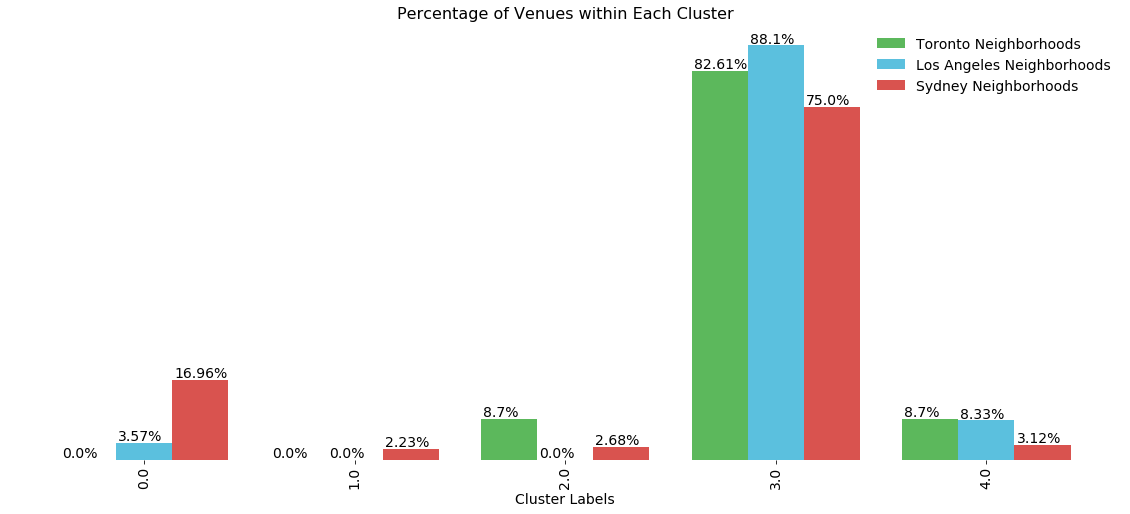

In [197]:
ax = merged_graph_df_USE.plot(kind = 'bar', width = 0.8, figsize = (20, 8), color = ["#5cb85c", "#5bc0de", "#d9534f"], fontsize = 14)
ax.set_xlabel('Cluster Labels', fontsize = 14)
ax.set_title('Percentage of Venues within Each Cluster', fontsize = 16)
ax.legend(fontsize = 14, frameon = False)
ax.yaxis.set_visible(False)
ax.set_facecolor('white')

empty_list = []
for sublist in merged_graph_df_USE.values.tolist():
    for item in sublist:
        empty_list.append(item)

for i in ax.patches:
    ax.text(i.get_x()+.01, i.get_height()+.5, str(i.get_height()) + '%', fontsize = 14)

for spine in ax.spines:
    ax.spines[spine].set_visible(False)

# Discussion

- All neighborhoods had the highest percentage of venues in Cluster 3.
- Sydney had the widest variety of venues (spanning all five clusters), followed by Toronto and Los Angeles.
- Out of these three cities, this means that Toronto and Los Angeles are most likely the most similar.

# Conclusion

Using the list of neighborhoods in three multicultural cities, Toronto, Los Angeles, and Sydney, as well as the Foursquare API data to find the top 10 most common venues, I segmented the neighborhoods into five clusters based on their top 10 most common venues. Comparing the distributions of these clusters for each individual city, I determined that Toronto and Los Angeles are most likely the most similar. In the future, more multicultural cities will be tested.